# AFL Match Predictors

In [1]:
from matplotlib import pyplot as plt
import json
plt.style.use(['mvstyle', 'one_piece'])

import numpy as np
import pandas as pd



## Data Processing 

In [2]:
import libs.data_processing as dp

Check if data needs to be retrieved from the API

In [3]:
dp.get_standings()
dp.get_seasonal_data()
dp.get_standings()

Combine all seasonal data into one DataFrame

In [4]:
full_data = dp.process_data()
full_data

,round,hteamid,ateamid,hrank,arank,hscore_ppg,ascore_ppg,hgoals_ppg,agoals_ppg,hbehinds_ppg,abehinds_ppg,hwins,awins,hlosses,alosses,is_final,hteamwin
0,1,3,19,5.000000,8.000000,81.000000,70.000000,11.000000,10.000000,15.000000,10.000000,1,0,0,1,0,1
1,1,10,11,3.000000,10.000000,104.000000,75.000000,15.000000,10.000000,14.000000,15.000000,1,0,0,1,0,1
2,1,15,12,2.000000,11.000000,134.000000,76.000000,20.000000,11.000000,14.000000,10.000000,1,0,0,1,0,1
3,1,14,4,6.000000,7.000000,105.000000,101.000000,16.000000,14.000000,9.000000,17.000000,1,0,0,1,0,1
4,1,16,7,4.000000,9.000000,73.000000,61.000000,10.000000,9.000000,13.000000,7.000000,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,20,14,15,5.944444,6.055556,68.222222,61.200000,10.000000,9.000000,8.222222,7.200000,13,11,5,8,4,1
158,20,7,4,4.833333,6.166667,80.200000,56.454545,12.000000,8.272727,8.200000,6.818182,13,10,6,8,4,1
159,21,13,14,1.000000,5.944444,70.181818,63.727273,10.181818,9.090909,9.090909,9.181818,15,14,4,5,5,0
160,21,2,7,3.611111,4.833333,71.636364,65.500000,10.000000,9.300000,11.636364,9.700000,15,14,4,6,5,0


## Neural Nets

In [5]:
import libs.neural_nets as mnn
import torch.nn as nn
import torch.optim as optim

### Process data for use in neural nets

In [6]:
main_data = mnn.PandasDataset(full_data)


train_proportion = 0.7
val_proportion = 1.0 - train_proportion

batch_size = 100

train_data, val_data = mnn.train_test_split(main_data, train_size=train_proportion, shuffle=True, random_state=42)

train_loader = mnn.DataLoader(train_data, 
                          shuffle=True, 
                          num_workers=2, 
                          batch_size=batch_size
                          )

val_loader = mnn.DataLoader(val_data, 
                        shuffle=True, 
                        num_workers=2, 
                        batch_size=batch_size
                        )

Test speed of data loader

In [7]:
import time
tstart=time.time()
num_iter=100
ctr=num_iter
for batch in train_loader:
    ctr -=100
    if ctr <= 0: break
print((time.time()-tstart)/num_iter,'[s/iteration]')

0.006756069660186767 [s/iteration]


### Dense Neural Net

Define the neural network architecture

In [8]:
hidden_nodes = 24
output_nodes = 3

input_num = main_data[0][0].__len__()
model = mnn.DenseNN(input_num, hidden_nodes, output_nodes)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):

  print("In epoch: ", epoch)
  
  running_loss_train = []
  running_loss_val = []
  
  index = 0
  
  for batch in train_loader:
      
      index = index + 1
      inputs, labels = batch
      # labels = labels.view(-1, 1) 
      optimizer.zero_grad()
      # print(labels)

      # Forward propagation
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      
      # Backward propagation and optimize
      loss.backward()
      optimizer.step()
      running_loss_train.append(loss.item())

      if index % 10 == 9:    # Print every 100 mini-batches
        print("batch: ", index, " loss = " , np.mean(np.asarray(running_loss_train)))

  print("End train epoch, mean loss: ", np.mean(np.asarray(running_loss_train)))
  index = 0
  for batch in val_loader:
      index = index+1
      inputs, labels = batch
      # labels = labels.view(-1, 1) 
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      running_loss_val.append(loss.item())
      if index % 10 == 9:    # Print every 100 mini-batches
        print("batch: ", index, " loss = " , np.mean(np.asarray(running_loss_val)))

  print("End val epoch, mean loss: ", np.mean(np.asarray(running_loss_val)))

print('Finished Training')

In epoch:  0
batch:  9  loss =  1.0074380834897358
batch:  19  loss =  0.9774882197380066
batch:  29  loss =  0.9553539383000341
batch:  39  loss =  0.9324250114269745
batch:  49  loss =  0.9140485890057622
batch:  59  loss =  0.8970812326770717
End train epoch, mean loss:  0.8847104293196949
batch:  9  loss =  0.7667224274741279
batch:  19  loss =  0.7751185862641585
batch:  29  loss =  0.7815842875118914
End val epoch, mean loss:  0.7815842875118914
In epoch:  1
batch:  9  loss =  0.7966020041041904
batch:  19  loss =  0.7828696087787026
batch:  29  loss =  0.7778245457287493
batch:  39  loss =  0.776265194782844
batch:  49  loss =  0.7732376638723879
batch:  59  loss =  0.7719157469474663
End train epoch, mean loss:  0.7711423226256868
batch:  9  loss =  0.7898509833547804
batch:  19  loss =  0.7684695061884428
batch:  29  loss =  0.7653786355051501
End val epoch, mean loss:  0.7653786355051501
In epoch:  2
batch:  9  loss =  0.7806131177478366
batch:  19  loss =  0.7751026090822721

Model working at 77.7% accuracy


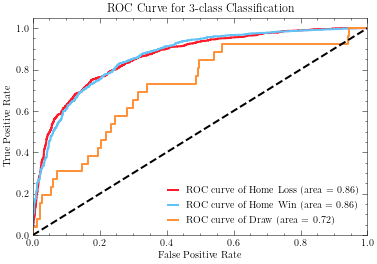

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_target = []
y_pred = []
for batch in val_loader:
      
      inputs, labels = batch
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      numpy_array = outputs.detach().numpy()
      y_target.extend(labels.numpy())
      y_pred.extend(numpy_array)


y_target = np.array(y_target)  # Example true labels
y_pred = np.array(y_pred)

pred_vals = [x.argmax() for x in y_pred]
mask = pred_vals == y_target
accuracy = mask.sum()/len(mask) * 100
print(f'Model working at {accuracy:0.1f}% accuracy')


target_labels = ["Home Loss", "Home Win", "Draw"]

def plot_roc_curve(y_true, y_pred_prob):

    # Binarize the labels
    y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])

    column_sums = np.sum(y_true_binarized, axis=0)
    # print(column_sums)
    # print(y_true_binarized)
    # print(y_pred_prob)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(target_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    # colors = ['blue', 'red', 'green', 'orange']
    for i in range(len(target_labels)):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(target_labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for 3-class Classification')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_target, y_pred)

Save the trained model for later use

In [10]:
from torch import save

save(model.state_dict(), 'AFL_prediction_model_DNN.pth')

## Predicting upcoming games

Load the saved model

In [22]:
from libs.neural_nets import DenseNN
from torch import load, tensor
from libs.data_processing import get_team_info, process_data, current_round_data

In [3]:
model = DenseNN(16, 24, 3) 
model.load_state_dict(load('AFL_prediction_model_DNN.pth', weights_only=True))

<All keys matched successfully>

In [4]:
team_dict = get_team_info()

In [20]:
full_data = process_data()

In [43]:
def predict(ateam, hteam, is_final):

    ateamid = team_dict[ateam]
    hteamid = team_dict[hteam]

    away_info = full_data[full_data['ateamid']==ateamid].iloc[-1][['round', 'ateamid', 'arank', 'ascore_ppg', 'agoals_ppg', 'abehinds_ppg', 'awins', 'alosses', 'is_final']]
    home_info = full_data[full_data['hteamid']==hteamid].iloc[-1][['hteamid', 'hrank', 'hscore_ppg', 'hgoals_ppg','hbehinds_ppg', 'hwins', 'hlosses']]
    
    input_data = pd.concat([away_info, home_info])[['round', 'hteamid', 'ateamid', 'hrank', 'arank', 'hscore_ppg', 'ascore_ppg', 'hgoals_ppg', 'agoals_ppg', 'hbehinds_ppg', 'abehinds_ppg', 'hwins', 'awins', 'hlosses', 'alosses', 'is_final']]
    input_data = tensor(input_data.values).float()

    model_output = model(input_data).detach().numpy()[0]

    output = model_output.argmax()

    if output == 0:
        return f'{ateam} to win with {model_output[0]:0.2f} probability'
    elif output == 1:
        return f'{hteam} to win with {model_output[1]:0.2f} probability'
    else:
        return f'Draw with {model_output[2]:0.2f} probability'

Predict the winners for the round!

In [44]:
current_round = 1
schedule = current_round_data(current_round)

for row in schedule.iterrows():
    row = row[1]
    print(predict(row['ateam'], row['hteam'], row['is_final']))

Sydney to win with 0.70 probability
Greater Western Sydney to win with 0.58 probability


Sydney to win
Greater Western Sydney to win
